## Random Forest-Music Recommendation 


In this sophisticated implementation of our music recommendation system, we employ a Random Forest classifier to predict user preferences based on a range of musical features. Initially, the ’track album release date’ within our song dataset is converted to datetime format to extract the ’release year’, which is then included as a feature to increase our model’s predictive capability. The features selected for modeling exclude ’track popularity’ to ensure unbiased predic- tions, forming a dataset designated as ’X r’‘. A binary target is generated from ’track popularity’, classifying songs as popular or not based on whether they exceed the 75th popularity percentile. The dataset is split into training and testing subsets with a 20% test allocation, ensuring a stratified distribution of the binary target. Prior to model training, missing values within the dataset are handled through dropping missing value, preparing the data for a robust training process. The Random Forest model, configured with 100 estimators, is trained on this preprocessed data. Following the training, the model’s efficacy in classification is assessed through standard metrics including accuracy, precision, recall, and F1-score, with detailed results provided in a classification report.
For user interaction, the system prompts for the title and artist of a song. If the song is located within the dataset, the system first re-applies the imputation to ensure data integrity. It then uses the trained model to predict the likelihood of user preference across the entire dataset, appending these probabilities back to
5 the main dataset.
To offer personalized recommendations, cosine similarity between the user-specified song and all songs in the dataset is calculated. Songs are then ranked according to both their predicted likelihood of preference and their similarity score, with the top 20 songs being selected. These recommendations are presented to the user, showcasing songs that align closely with their expressed preferences based on both predictive likelihood and feature similarity.
In addition, these top recommendations are saved to a CSV file, providing a tangible output for further analysis or external use. If the user’s song is not found, the system provides a prompt notification, maintaining clear and effective communication.

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from yellowbrick.target import FeatureCorrelation
from sklearn.preprocessing import LabelEncoder
import plotly.express as px
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

In [2]:
# Reading a csv
song_data = pd.read_csv('spotify_song.csv')

In [3]:
# display header
song_data.head()

,Unnamed: 0,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,6/14/2019,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,...,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),12/13/2019,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,...,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),7/5/2019,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,...,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,7/19/2019,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,...,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),3/5/2019,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,...,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


In [4]:
song_data.shape

(32833, 24)

In [5]:
#DataFrame information
song_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                32833 non-null  int64  
 1   track_id                  32833 non-null  object 
 2   track_name                32828 non-null  object 
 3   track_artist              32828 non-null  object 
 4   track_popularity          32833 non-null  int64  
 5   track_album_id            32833 non-null  object 
 6   track_album_name          32828 non-null  object 
 7   track_album_release_date  32833 non-null  object 
 8   playlist_name             32833 non-null  object 
 9   playlist_id               32833 non-null  object 
 10  playlist_genre            32833 non-null  object 
 11  playlist_subgenre         32833 non-null  object 
 12  danceability              32833 non-null  float64
 13  energy                    32833 non-null  float64
 14  key   

In [6]:
# Check if we have duplicates.
song_data.duplicated().sum()

0

In [7]:
# Check the data for columns with missing numbers (i.e. np.NaN).
song_data.isnull().sum()

Unnamed: 0                  0
track_id                    0
track_name                  5
track_artist                5
track_popularity            0
track_album_id              0
track_album_name            5
track_album_release_date    0
playlist_name               0
playlist_id                 0
playlist_genre              0
playlist_subgenre           0
danceability                0
energy                      0
key                         0
loudness                    0
mode                        0
speechiness                 0
acousticness                0
instrumentalness            0
liveness                    0
valence                     0
tempo                       0
duration_ms                 0
dtype: int64

In [8]:
#Drop the missing values
song_data.dropna(inplace=True)

#check for missing values again
song_data.isnull().sum()

Unnamed: 0                  0
track_id                    0
track_name                  0
track_artist                0
track_popularity            0
track_album_id              0
track_album_name            0
track_album_release_date    0
playlist_name               0
playlist_id                 0
playlist_genre              0
playlist_subgenre           0
danceability                0
energy                      0
key                         0
loudness                    0
mode                        0
speechiness                 0
acousticness                0
instrumentalness            0
liveness                    0
valence                     0
tempo                       0
duration_ms                 0
dtype: int64

In [9]:
# Initialize the LabelEncoder
encoder = LabelEncoder()
# Encode the 'track_id' column to convert string identifiers into numerical labels
song_data['track_id'] = encoder.fit_transform(song_data['track_id'])

# Convert the encoded 'track_id' to float64 data type for numerical consistency
song_data['track_id'] = song_data['track_id'].astype('float64')

# Display the 'track_id' column after encoding
song_data['track_id']

0        24146.0
1         3061.0
2         7219.0
3        25695.0
4         5987.0
          ...   
32828    26852.0
32829    18773.0
32830    26461.0
32831    10083.0
32832     7864.0
Name: track_id, Length: 32828, dtype: float64

In [10]:
# Selecting features for modeling from the 'song_data'.

features = song_data[['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
                         'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'mode', 'key']]

In [11]:
# Import necessary library
from scipy.stats.mstats import winsorize

#It applies winsorization to the dataset, replacing outliers in 
#specified columns with values at the 5th and 95th percentiles.
# Define a function to winsorize outliers

def handle_outliers_winsorize(df):
    # Apply winsorization to each column containing outliers
    columns_with_outliers = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'tempo', 'duration_ms', 'key', 'mode']
    for col in columns_with_outliers:
        song_data.loc[:, col] = winsorize(song_data[col], limits=[0.05, 0.05])  # Winsorize at the 5th and 95th percentiles
    return song_data

# Apply winsorization to your dataset
song_data = handle_outliers_winsorize(song_data)
song_data.head()

,Unnamed: 0,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,0,24146.0,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,6/14/2019,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,...,6,-2.972,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,1,3061.0,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),12/13/2019,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,...,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,2,7219.0,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),7/5/2019,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,...,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,3,25695.0,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,7/19/2019,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,...,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,4,5987.0,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),3/5/2019,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,...,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


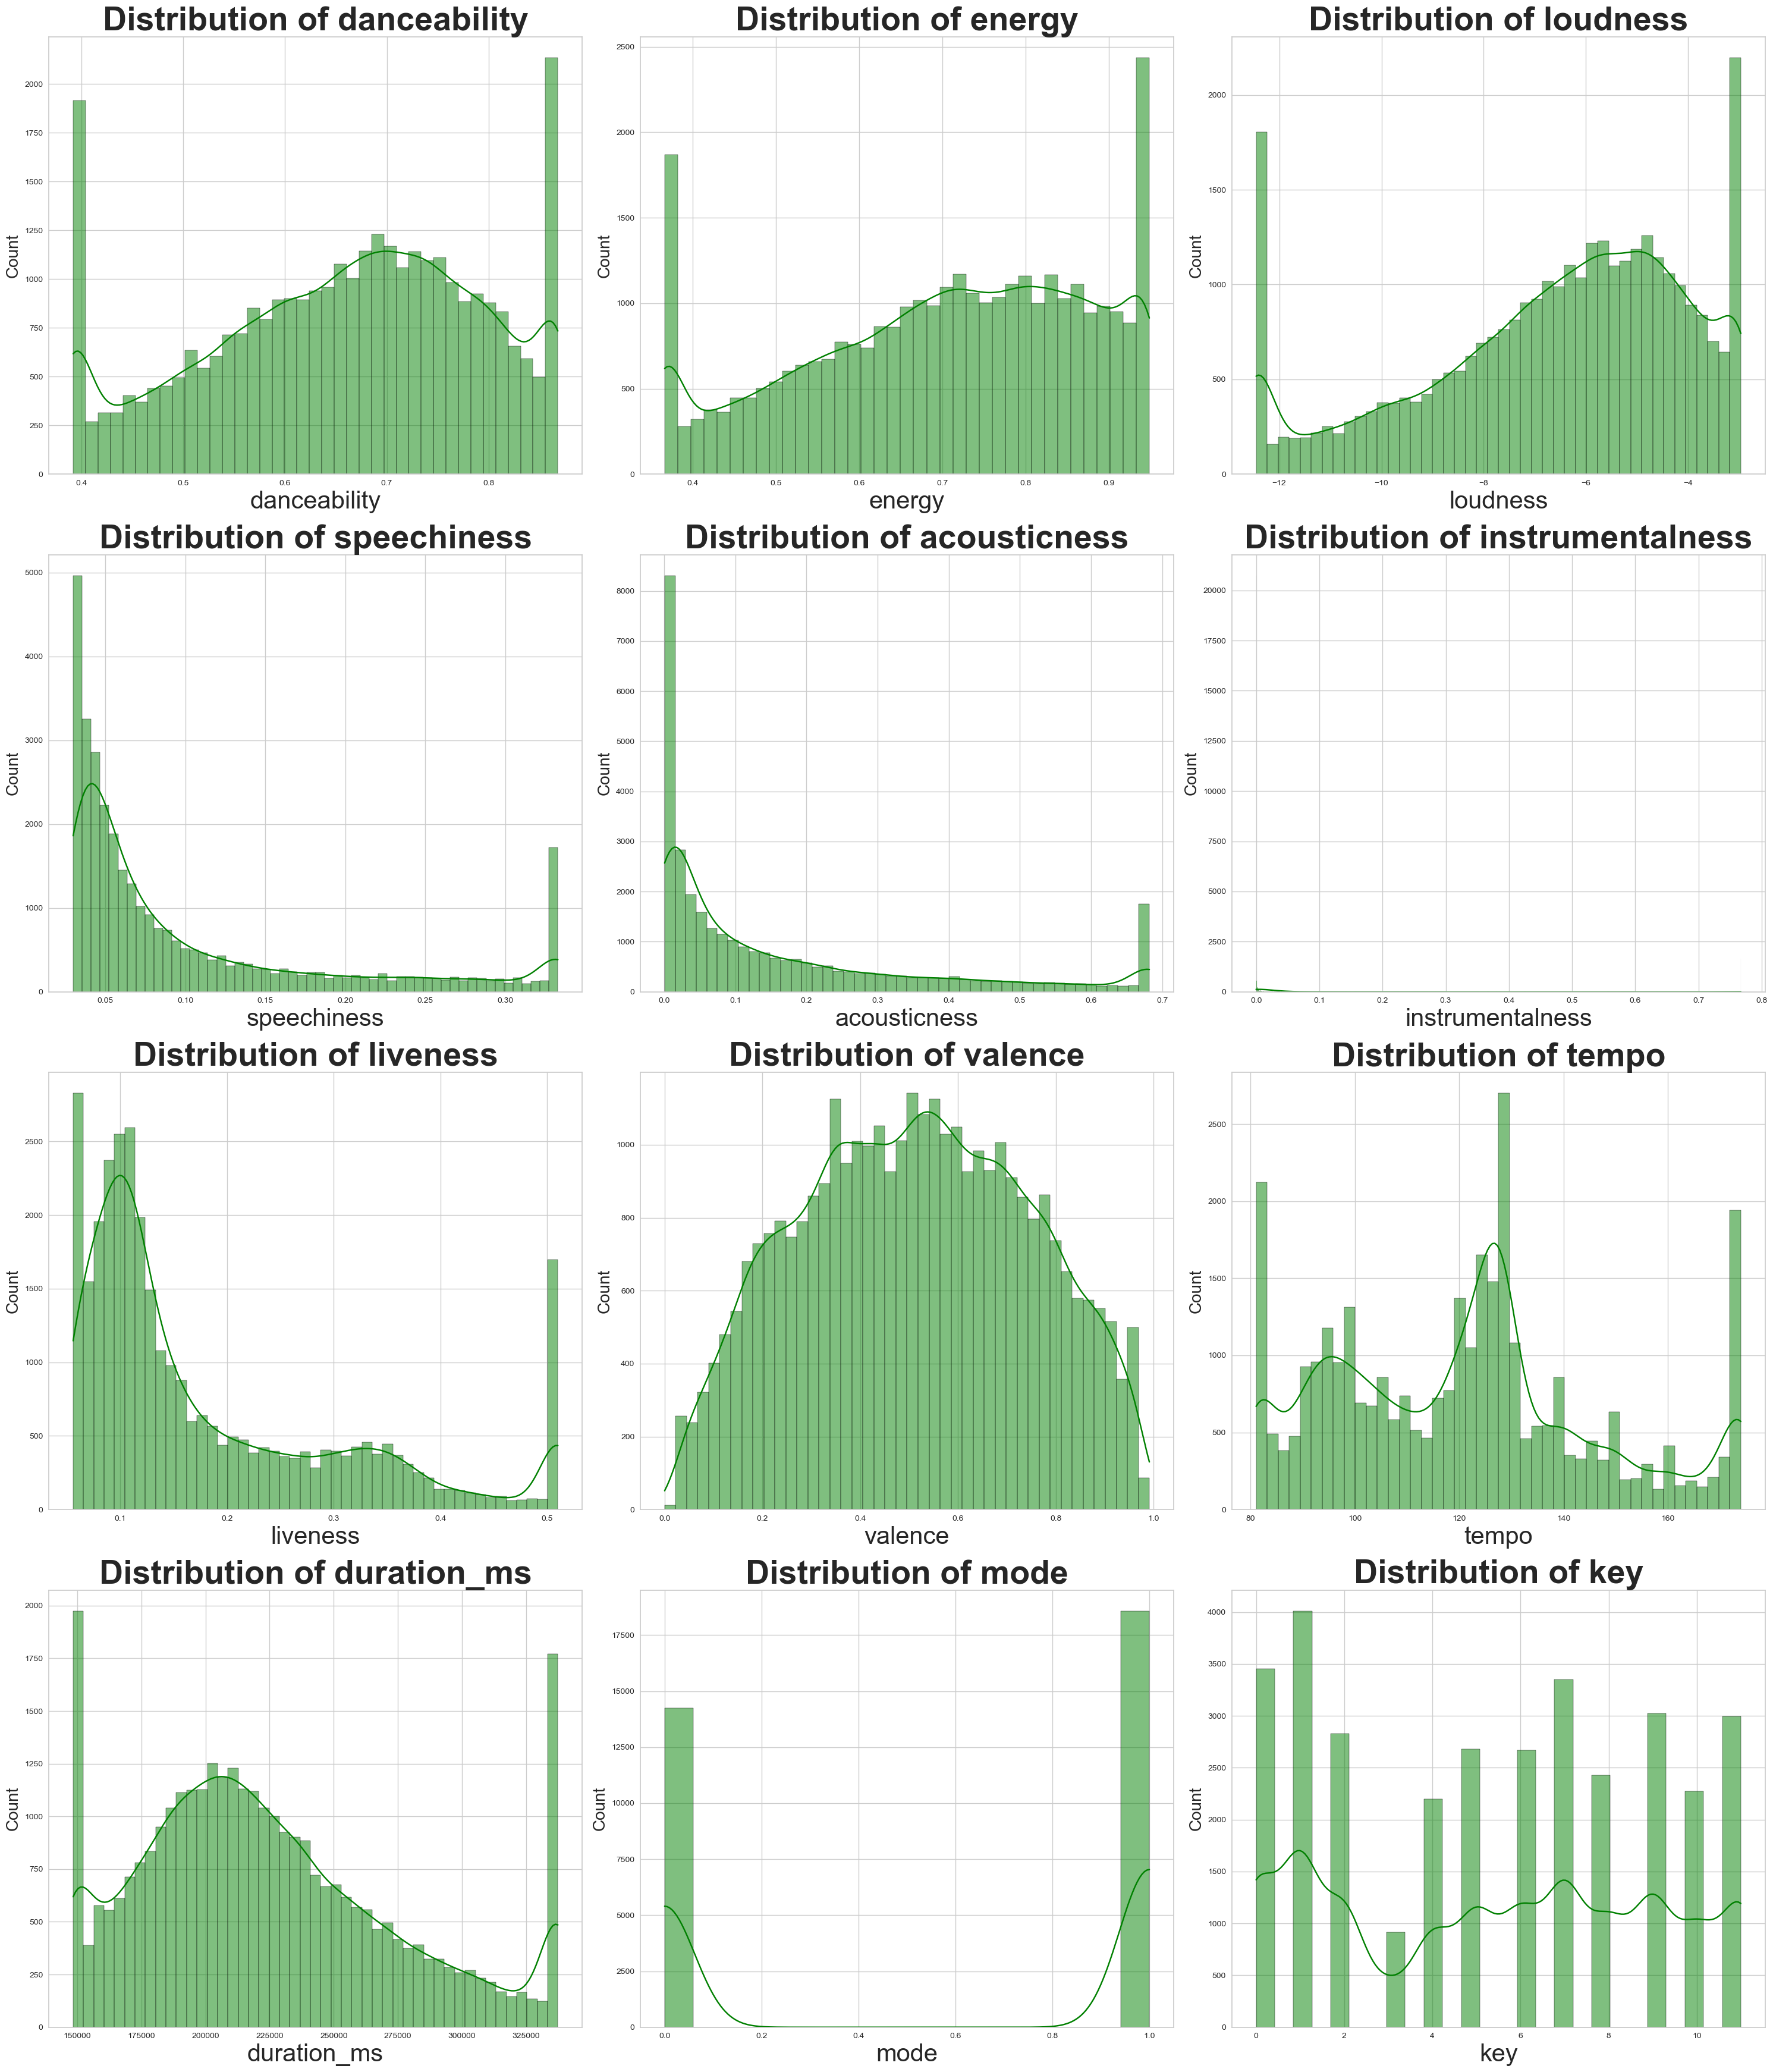

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create distribution plots for each numerical feature
plt.figure(figsize=(30, 35))

for i, feature in enumerate(features, 1):
    plt.subplot(4, 3, i)
    sns.histplot(song_data[feature], kde=True, color='green')
    
    # Set title with increased font size and bold font weight
    plt.title('Distribution of {}'.format(feature), fontweight='bold', fontsize=40)
    
    # Set x and y axis labels with increased font size
    plt.xlabel(feature, fontsize=30)
    plt.ylabel('Count', fontsize=20)
    
plt.tight_layout()  # Adjust the layout to prevent overlapping
plt.show()


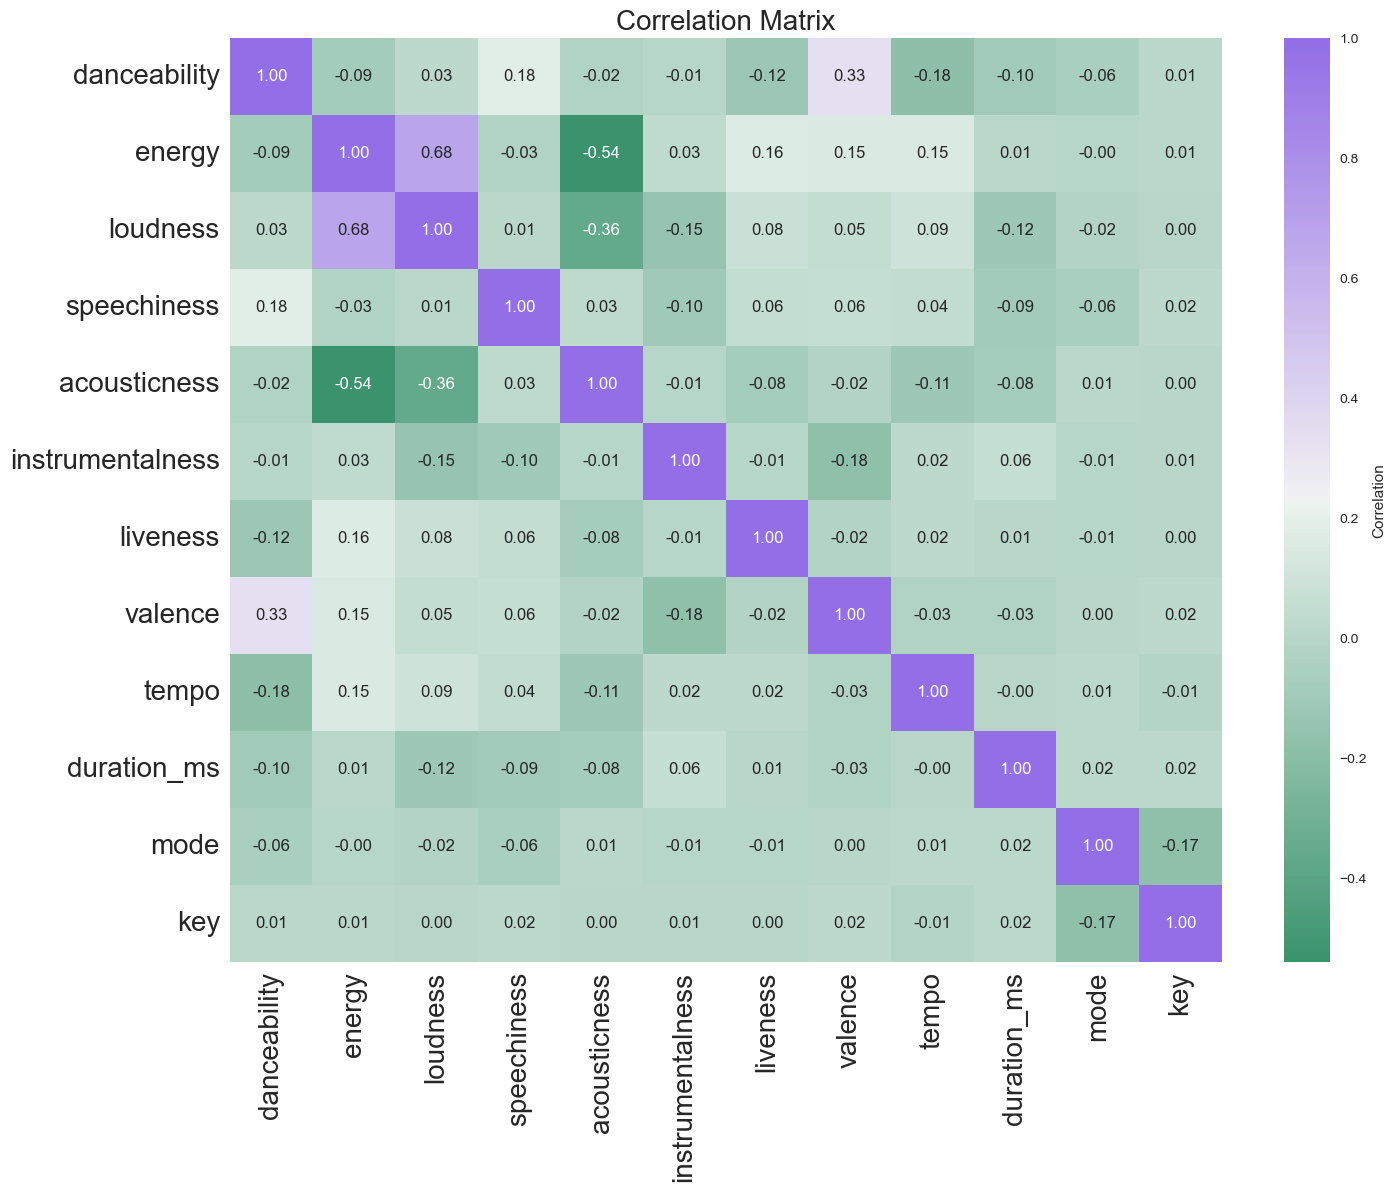

In [13]:
# Calculate correlation matrix
corr_matrix = features.corr()

# Create custom 'coolwarm' colormap leaning towards green
cmap = sns.diverging_palette(150, 275, s=80, l=55, as_cmap=True)

# Plot heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, cmap=cmap, cbar_kws={'label': 'Correlation'}, fmt=".2f")
plt.title('Correlation Matrix', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()


In [14]:
# List of features selected based on correlation analysis.

correlated_features = ['danceability', 'valence', 'energy', 'loudness', 
                        'speechiness', 'track_id', 'acousticness']

X = song_data[correlated_features].fillna(0)

In [15]:
# Convert 'track_album_release_date' to datetime and extract the year
song_data['track_album_release_date'] = pd.to_datetime(song_data['track_album_release_date'], errors='coerce', infer_datetime_format=True)
song_data['release_year'] = song_data['track_album_release_date'].dt.year
correlated_features.append('release_year')

# Drop rows with missing values
song_data.dropna(inplace=True)

# Check for missing values again to ensure there are none
missing_values = song_data.isnull().sum()

# Selecting features for modeling
features_for_modeling = [feature for feature in correlated_features if feature != 'track_popularity']

X_rf = song_data[features_for_modeling]

# Creating a binary target based on 'track_popularity'
popularity_threshold = song_data['track_popularity'].quantile(0.75)
y = (song_data['track_popularity'] >= popularity_threshold).astype(int)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X_rf, y, test_size=0.2, random_state=42, stratify=y)

# Training the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Making predictions on the testing set
y_pred = rf_model.predict(X_test)

# Calculating and printing the classification metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F-Score: {f_score}")

/var/folders/6l/833kmrd95qs1wbnrjmr5fx_w0000gn/T/ipykernel_40505/1081065488.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  song_data['track_album_release_date'] = pd.to_datetime(song_data['track_album_release_date'], errors='coerce', infer_datetime_format=True)


Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.97      0.91      4580
           1       0.87      0.52      0.65      1609

    accuracy                           0.86      6189
   macro avg       0.86      0.75      0.78      6189
weighted avg       0.86      0.86      0.84      6189

Accuracy: 0.8550654386815317
Precision: 0.8700623700623701
Recall: 0.5201988812927284
F-Score: 0.6511085180863477


In [16]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sklearn.impute import SimpleImputer

# User input for song and artist
input_song_title = input("Enter the title of a song: ")
input_artist = input("Enter the artist of the song: ")

# Find the user's song in the dataset
user_song = song_data[(song_data['track_name'] == input_song_title) & (song_data['track_artist'] == input_artist)]

if not user_song.empty:
    # Predict the likelihood of liking for the dataset used in model training
    imputer = SimpleImputer(strategy='mean')
    X_rf_imputed = imputer.fit_transform(X_rf)
    user_song_features_imputed = imputer.transform(user_song[features_for_modeling].values)
    
    probabilities = rf_model.predict_proba(X_rf_imputed)[:, 1]
    
    # Update the main DataFrame with predicted likelihood
    song_data['predicted_likelihood'] = probabilities

    # Calculate cosine similarity for the user's song
    similarities = cosine_similarity(user_song_features_imputed, X_rf_imputed).flatten()
    
    # Filter and sort the DataFrame based on 'predicted_likelihood'
    sorted_indices = np.argsort(-probabilities)  # Indices of songs sorted by decreasing likelihood
    top_similarities_indices = sorted_indices[:20]  # Assuming you want top 20 recommendations
    
    top_recommendations = song_data.iloc[top_similarities_indices].copy()
    top_recommendations['similarity'] = similarities[top_similarities_indices]  # Assign similarities to the top recommendations
    
    print("Top 20 recommended songs based on predicted likelihood of being 'liked' and cosine similarity:")
    print(top_recommendations[['track_name', 'track_artist','release_year', 'predicted_likelihood', 'similarity']])
    
    # Save top recommendations to CSV file
    output_file = "top20_recommendations.csv"
    top_recommendations[['track_name', 'track_artist','release_year', 'predicted_likelihood', 'similarity']].to_csv(output_file, index=False)
    
    print(f"Top recommendations saved to {output_file}")
    
    
else:
    print("Sorry, the input song is not found in the database.")


Enter the title of a song: Memories
Enter the artist of the song: Maroon 5


/Users/emd/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/Users/emd/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Top 20 recommended songs based on predicted likelihood of being 'liked' and cosine similarity:
                      track_name         track_artist  release_year  \
4659         If I Can't Have You         Shawn Mendes        2019.0   
646                      Ride It               Regard        2019.0   
23103                       Tusa              KAROL G        2019.0   
1738    One Kiss (with Dua Lipa)        Calvin Harris        2018.0   
30388        Lose You To Love Me         Selena Gomez        2019.0   
30386              Calma - Remix           Pedro Capó        2018.0   
23104                    ROXANNE       Arizona Zervas        2019.0   
19197                  Con Calma         Daddy Yankee        2019.0   
30672                       Ride    Twenty One Pilots        2015.0   
1731       Closer (feat. Halsey)     The Chainsmokers        2016.0   
30392                    ROXANNE       Arizona Zervas        2019.0   
23105            Don't Start Now             Dua Lipa